# Predicting H1N1 vaccination refusal using best features 
## Features selected from XGBoost Classifier

This notebook uses 15 best features as selected using as XGBoost Classifier. The features are lsited below:
 
* `opinion_h1n1_vacc_effective`
* `health_insurance`
* `opinion_h1n1_risk1`
* `h1n1_knowledge`
* `behavioral_large_gatherings`
* `marital_status`
* `rent_or_own`
* `behavioral_touch_face`
* `opinion_seas_risk`
* `opinion_seas_vacc_effective`
* `education`
* `behavioral_avoidance`
* `doctor_recc_h1n1`
* `behavioral_outside_home'`
* `household_adults`
* `h1n1_vaccine`
* `seasonal_vaccine`


The notebook runs three kinds of models. 

1. Using best features and engineered features, and balancing classes using SMOTE
2. Using features as is, and SMOTE for balancing features
3. Using features and imbalanced classes as is

The findings are summarized belo along with the results from the previous notebook that used features from a logistic regression model

Model|Accuracy|Precision|Recall|AUC|
-----|--------|---------|------|---|
Logistic Regression feat.engg + SMOTE|0.817|0.899|0.865|0.753|
Logistic Regression feat as is + SMOTE|0.824|0.901|0.873|0.759|
Logistic Regression feat as is|0.851|0.876|0.944|0.725|
XGBoost feat.engg + SMOTE|0.839|0.886|0.913|0.740|
XGBoost feat as is + SMOTE|0.839|0.886|0.913|0.739|
XGBoost feat. as is|0.847|0.871|0.945|0.714|

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, recall_score, precision_score, 
                            roc_auc_score, balanced_accuracy_score, ConfusionMatrixDisplay)

C:\ProgramData\Anaconda3\envs\xgboost\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Using features from XGBoost List with feature engineering and SMOTE

In [2]:
# import data
data = pd.read_csv('../data/train_clean.csv')

In [3]:
data.columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation', 'h1n1_vaccine', 'seasonal_vaccine'],
      dtype='object')

In [4]:
data['h1n1_vaccine'].value_counts(normalize=True)

0    0.787546
1    0.212454
Name: h1n1_vaccine, dtype: float64

In [5]:
data['seasonal_vaccine'].value_counts(normalize=True)

0    0.534392
1    0.465608
Name: seasonal_vaccine, dtype: float64

In [6]:
# since we're interested in the people who did not get vaccinated: switch 0 and 1 labels
data['h1n1_vaccine'].replace({1:0, 0:1}, inplace=True)
data['h1n1_vaccine'].value_counts()

data['seasonal_vaccine'].replace({1:0, 0:1}, inplace=True)
data['seasonal_vaccine'].value_counts()

1    14272
0    12435
Name: seasonal_vaccine, dtype: int64

In [7]:
features_to_use = pd.read_csv('../data/XGB_H1N1_feature_imp.csv')

In [8]:
features = list(features_to_use['feature'])
features.append('h1n1_vaccine')
features.append('seasonal_vaccine')
features

['opinion_h1n1_vacc_effective',
 'health_insurance',
 'opinion_h1n1_risk',
 'h1n1_knowledge',
 'behavioral_large_gatherings',
 'marital_status',
 'rent_or_own',
 'behavioral_touch_face',
 'opinion_seas_risk',
 'opinion_seas_vacc_effective',
 'education',
 'behavioral_avoidance',
 'doctor_recc_h1n1',
 'behavioral_outside_home',
 'household_adults',
 'h1n1_vaccine',
 'seasonal_vaccine']

In [9]:
data = data[features]

In [10]:
data.columns

Index(['opinion_h1n1_vacc_effective', 'health_insurance', 'opinion_h1n1_risk',
       'h1n1_knowledge', 'behavioral_large_gatherings', 'marital_status',
       'rent_or_own', 'behavioral_touch_face', 'opinion_seas_risk',
       'opinion_seas_vacc_effective', 'education', 'behavioral_avoidance',
       'doctor_recc_h1n1', 'behavioral_outside_home', 'household_adults',
       'h1n1_vaccine', 'seasonal_vaccine'],
      dtype='object')

Doctor recommended features

In [11]:
# #####
data['doctor_recc_h1n1'].value_counts()

0.0            19139
1.0             5408
no_response     2160
Name: doctor_recc_h1n1, dtype: int64

In [12]:
data['doctor_recc_h1n1'].dtypes

dtype('O')

In [13]:
data['doctor_recc_h1n1'] = data['doctor_recc_h1n1'].replace({'0.0': 1, '1.0': 2, 'no_response': 0})

data['doctor_recc_h1n1'].value_counts()

1    19139
2     5408
0     2160
Name: doctor_recc_h1n1, dtype: int64

In [14]:
# make a new feature h1n1_all for participants who responded yes to all the behavior questions
behaviour_columns = [column for column in list(data.columns) if 'behavioral' in column]
data[behaviour_columns].dtypes

behavioral_large_gatherings    float64
behavioral_touch_face          float64
behavioral_avoidance           float64
behavioral_outside_home        float64
dtype: object

In [15]:
data['behavioral_all'] = 1

for column in behaviour_columns:
    data['behavioral_all'] = data['behavioral_all'] * data[column]

In [16]:
# make a new feature opinion_all for participants based on their opinion scores to the opinion questions
opinion_columns = [column for column in list(data.columns) if 'opinion' in column]
data[opinion_columns].dtypes

opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_seas_risk              float64
opinion_seas_vacc_effective    float64
dtype: object

In [17]:
data['opinion_all'] = 1

for column in opinion_columns:
    data['opinion_all'] = data['opinion_all'] * data[column]

In [18]:
data.columns

Index(['opinion_h1n1_vacc_effective', 'health_insurance', 'opinion_h1n1_risk',
       'h1n1_knowledge', 'behavioral_large_gatherings', 'marital_status',
       'rent_or_own', 'behavioral_touch_face', 'opinion_seas_risk',
       'opinion_seas_vacc_effective', 'education', 'behavioral_avoidance',
       'doctor_recc_h1n1', 'behavioral_outside_home', 'household_adults',
       'h1n1_vaccine', 'seasonal_vaccine', 'behavioral_all', 'opinion_all'],
      dtype='object')

**dummify x**

In [19]:
categorical_columns = list(data.select_dtypes('object').columns)
categorical_columns

['health_insurance', 'marital_status', 'rent_or_own', 'education']

In [20]:
X = pd.get_dummies(data=data.drop(columns=['h1n1_vaccine', 'seasonal_vaccine']),
                    columns=categorical_columns, drop_first=True)

**define X and y**

In [21]:
X.columns

Index(['opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'h1n1_knowledge',
       'behavioral_large_gatherings', 'behavioral_touch_face',
       'opinion_seas_risk', 'opinion_seas_vacc_effective',
       'behavioral_avoidance', 'doctor_recc_h1n1', 'behavioral_outside_home',
       'household_adults', 'behavioral_all', 'opinion_all',
       'health_insurance_no_response', 'health_insurance_yes',
       'marital_status_Not Married', 'marital_status_no_response',
       'rent_or_own_Rent', 'rent_or_own_no_response', 'education_< 12 Years',
       'education_College Graduate', 'education_Some College',
       'education_no_response'],
      dtype='object')

In [22]:
y = data['h1n1_vaccine']

In [23]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [24]:
# balance classes

smo = SMOTE(k_neighbors=7, random_state=42)

X_train_over, y_train_over = smo.fit_resample(X_train, y_train)


In [25]:
X_train_over = np.array(X_train_over)
X_test = np.array(X_test)

In [26]:
y_train_over = np.array(y_train_over)
y_test = np.array(y_test)

In [27]:
X.columns

Index(['opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'h1n1_knowledge',
       'behavioral_large_gatherings', 'behavioral_touch_face',
       'opinion_seas_risk', 'opinion_seas_vacc_effective',
       'behavioral_avoidance', 'doctor_recc_h1n1', 'behavioral_outside_home',
       'household_adults', 'behavioral_all', 'opinion_all',
       'health_insurance_no_response', 'health_insurance_yes',
       'marital_status_Not Married', 'marital_status_no_response',
       'rent_or_own_Rent', 'rent_or_own_no_response', 'education_< 12 Years',
       'education_College Graduate', 'education_Some College',
       'education_no_response'],
      dtype='object')

**Run model**

In [28]:
xgb_best = xgb.XGBClassifier(random_state=42,
                             use_label_encoder=False,
                             eval_metric='error',
                             booster='gbtree',
                             colsample_bytree=0.9,
                             learning_rate=0.05,
                             max_depth=3,
                             n_estimators=600,
                             subsample=1)
xgb_best.fit(X_train_over, y_train_over)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9,
              enable_categorical=False, eval_metric='error', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=600, n_jobs=16, num_parallel_tree=1,
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [29]:
test_pred = xgb_best.predict(X_test)
train_pred = xgb_best.predict(X_train)

C:\ProgramData\Anaconda3\envs\xgboost\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


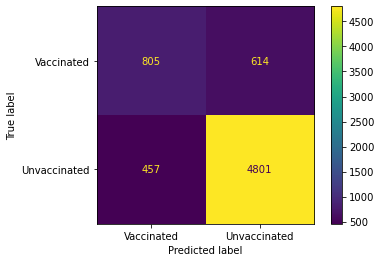

In [30]:
ConfusionMatrixDisplay.from_predictions(y_test, test_pred, display_labels=['Vaccinated', 'Unvaccinated'])

In [31]:
accuracy_score(y_test, test_pred), accuracy_score(y_train, train_pred)

(0.8395986221356897, 0.843884173739391)

In [32]:
precision_score(y_test, test_pred)

0.8866112650046168

In [33]:
recall_score(y_test, test_pred)

0.9130848231266642

In [34]:
roc_auc_score(y_test, test_pred)

0.740192869632395

In [35]:
balanced_accuracy_score(y_test, test_pred)

0.7401928696323947

Model|Accuracy|Precision|Recall|AUC|
-----|--------|---------|------|---|
LR feat.engg + SMOTE|0.817|0.899|0.865|0.753|
LR feat as is + SMOTE|0.824|0.901|0.873|0.759|
LR feat as is|0.851|0.876|0.944|0.725|
XGB feat.engg + SMOTE|0.839|0.886|0.913|0.740|
XGB feat as is + SMOTE|0.839|0.886|0.913|0.739|
XGB feat. as is|0.847|0.871|0.945|0.714|

### Using top features from XGBoost, without feature engineering, but with SMOTE

In [50]:
# import data
data = pd.read_csv('../data/train_clean.csv')

In [51]:
data.columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation', 'h1n1_vaccine', 'seasonal_vaccine'],
      dtype='object')

In [52]:
data['h1n1_vaccine'].value_counts(normalize=True)

0    0.787546
1    0.212454
Name: h1n1_vaccine, dtype: float64

In [53]:
data['seasonal_vaccine'].value_counts(normalize=True)

0    0.534392
1    0.465608
Name: seasonal_vaccine, dtype: float64

In [54]:
# since we're interested in the people who did not get vaccinated: switch 0 and 1 labels
data['h1n1_vaccine'].replace({1:0, 0:1}, inplace=True)
data['h1n1_vaccine'].value_counts()

data['seasonal_vaccine'].replace({1:0, 0:1}, inplace=True)
data['seasonal_vaccine'].value_counts()

1    14272
0    12435
Name: seasonal_vaccine, dtype: int64

In [55]:
features_to_use = pd.read_csv('../data/XGB_H1N1_feature_imp.csv')

In [56]:
features = list(features_to_use['feature'])
features.append('h1n1_vaccine')
features.append('seasonal_vaccine')
features

['opinion_h1n1_vacc_effective',
 'health_insurance',
 'opinion_h1n1_risk',
 'h1n1_knowledge',
 'behavioral_large_gatherings',
 'marital_status',
 'rent_or_own',
 'behavioral_touch_face',
 'opinion_seas_risk',
 'opinion_seas_vacc_effective',
 'education',
 'behavioral_avoidance',
 'doctor_recc_h1n1',
 'behavioral_outside_home',
 'household_adults',
 'h1n1_vaccine',
 'seasonal_vaccine']

In [57]:
data = data[features]

In [58]:
data.columns

Index(['opinion_h1n1_vacc_effective', 'health_insurance', 'opinion_h1n1_risk',
       'h1n1_knowledge', 'behavioral_large_gatherings', 'marital_status',
       'rent_or_own', 'behavioral_touch_face', 'opinion_seas_risk',
       'opinion_seas_vacc_effective', 'education', 'behavioral_avoidance',
       'doctor_recc_h1n1', 'behavioral_outside_home', 'household_adults',
       'h1n1_vaccine', 'seasonal_vaccine'],
      dtype='object')

**dummify x**

In [59]:
categorical_columns = list(data.select_dtypes('object').columns)
categorical_columns

['health_insurance',
 'marital_status',
 'rent_or_own',
 'education',
 'doctor_recc_h1n1']

In [60]:
X = pd.get_dummies(data=data.drop(columns=['h1n1_vaccine', 'seasonal_vaccine']),
                    columns=categorical_columns, drop_first=True)

**define X and y**

In [61]:
X.columns

Index(['opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'h1n1_knowledge',
       'behavioral_large_gatherings', 'behavioral_touch_face',
       'opinion_seas_risk', 'opinion_seas_vacc_effective',
       'behavioral_avoidance', 'behavioral_outside_home', 'household_adults',
       'health_insurance_no_response', 'health_insurance_yes',
       'marital_status_Not Married', 'marital_status_no_response',
       'rent_or_own_Rent', 'rent_or_own_no_response', 'education_< 12 Years',
       'education_College Graduate', 'education_Some College',
       'education_no_response', 'doctor_recc_h1n1_1.0',
       'doctor_recc_h1n1_no_response'],
      dtype='object')

In [62]:
y = data['h1n1_vaccine']

In [63]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [64]:
# balance classes

smo = SMOTE(k_neighbors=7, random_state=42)

X_train_over, y_train_over = smo.fit_resample(X_train, y_train)


In [65]:
X_train_over = np.array(X_train_over)
X_test = np.array(X_test)

In [66]:
y_train_over = np.array(y_train_over)
y_test = np.array(y_test)

In [67]:
X.columns

Index(['opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'h1n1_knowledge',
       'behavioral_large_gatherings', 'behavioral_touch_face',
       'opinion_seas_risk', 'opinion_seas_vacc_effective',
       'behavioral_avoidance', 'behavioral_outside_home', 'household_adults',
       'health_insurance_no_response', 'health_insurance_yes',
       'marital_status_Not Married', 'marital_status_no_response',
       'rent_or_own_Rent', 'rent_or_own_no_response', 'education_< 12 Years',
       'education_College Graduate', 'education_Some College',
       'education_no_response', 'doctor_recc_h1n1_1.0',
       'doctor_recc_h1n1_no_response'],
      dtype='object')

**Run model**

In [68]:
xgb_best = xgb.XGBClassifier(random_state=42,
                             use_label_encoder=False,
                             eval_metric='error',
                             booster='gbtree',
                             colsample_bytree=0.9,
                             learning_rate=0.05,
                             max_depth=3,
                             n_estimators=600,
                             subsample=1)
xgb_best.fit(X_train_over, y_train_over)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9,
              enable_categorical=False, eval_metric='error', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=600, n_jobs=16, num_parallel_tree=1,
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [69]:
test_pred = xgb_best.predict(X_test)
train_pred = xgb_best.predict(X_train)

C:\ProgramData\Anaconda3\envs\xgboost\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


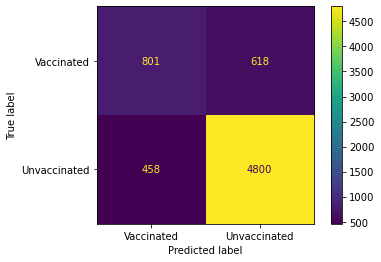

In [70]:
ConfusionMatrixDisplay.from_predictions(y_test, test_pred, display_labels=['Vaccinated', 'Unvaccinated'])

In [71]:
accuracy_score(y_test, test_pred), accuracy_score(y_train, train_pred)

(0.8388497828366033, 0.844882675986021)

In [72]:
precision_score(y_test, test_pred)

0.8859357696566998

In [73]:
recall_score(y_test, test_pred)

0.9128946367440092

In [74]:
roc_auc_score(y_test, test_pred)

0.7386883331711589

In [75]:
balanced_accuracy_score(y_test, test_pred)

0.7386883331711589

Model|Accuracy|Precision|Recall|AUC|
-----|--------|---------|------|---|
LR feat.engg + SMOTE|0.817|0.899|0.865|0.753|
LR feat as is + SMOTE|0.824|0.901|0.873|0.759|
LR feat as is|0.851|0.876|0.944|0.725|
XGB feat.engg + SMOTE|0.830|0.880|0.91|0.74|
XGB feat as is + SMOTE|0.839|0.886|0.913|0.739|

### Using top features from XGBoost without feature engineering or smote

In [76]:
# import data
data = pd.read_csv('../data/train_clean.csv')

In [77]:
data.columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation', 'h1n1_vaccine', 'seasonal_vaccine'],
      dtype='object')

In [78]:
data['h1n1_vaccine'].value_counts(normalize=True)

0    0.787546
1    0.212454
Name: h1n1_vaccine, dtype: float64

In [79]:
data['seasonal_vaccine'].value_counts(normalize=True)

0    0.534392
1    0.465608
Name: seasonal_vaccine, dtype: float64

In [80]:
# since we're interested in the people who did not get vaccinated: switch 0 and 1 labels
data['h1n1_vaccine'].replace({1:0, 0:1}, inplace=True)
data['h1n1_vaccine'].value_counts()

data['seasonal_vaccine'].replace({1:0, 0:1}, inplace=True)
data['seasonal_vaccine'].value_counts()

1    14272
0    12435
Name: seasonal_vaccine, dtype: int64

In [81]:
features_to_use = pd.read_csv('../data/XGB_H1N1_feature_imp.csv')

In [82]:
features = list(features_to_use['feature'])
features.append('h1n1_vaccine')
features.append('seasonal_vaccine')
features

['opinion_h1n1_vacc_effective',
 'health_insurance',
 'opinion_h1n1_risk',
 'h1n1_knowledge',
 'behavioral_large_gatherings',
 'marital_status',
 'rent_or_own',
 'behavioral_touch_face',
 'opinion_seas_risk',
 'opinion_seas_vacc_effective',
 'education',
 'behavioral_avoidance',
 'doctor_recc_h1n1',
 'behavioral_outside_home',
 'household_adults',
 'h1n1_vaccine',
 'seasonal_vaccine']

In [83]:
data = data[features]

In [84]:
data.columns

Index(['opinion_h1n1_vacc_effective', 'health_insurance', 'opinion_h1n1_risk',
       'h1n1_knowledge', 'behavioral_large_gatherings', 'marital_status',
       'rent_or_own', 'behavioral_touch_face', 'opinion_seas_risk',
       'opinion_seas_vacc_effective', 'education', 'behavioral_avoidance',
       'doctor_recc_h1n1', 'behavioral_outside_home', 'household_adults',
       'h1n1_vaccine', 'seasonal_vaccine'],
      dtype='object')

**dummify x**

In [85]:
categorical_columns = list(data.select_dtypes('object').columns)
categorical_columns

['health_insurance',
 'marital_status',
 'rent_or_own',
 'education',
 'doctor_recc_h1n1']

In [86]:
X = pd.get_dummies(data=data.drop(columns=['h1n1_vaccine', 'seasonal_vaccine']),
                    columns=categorical_columns, drop_first=True)

**define X and y**

In [87]:
X.columns

Index(['opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'h1n1_knowledge',
       'behavioral_large_gatherings', 'behavioral_touch_face',
       'opinion_seas_risk', 'opinion_seas_vacc_effective',
       'behavioral_avoidance', 'behavioral_outside_home', 'household_adults',
       'health_insurance_no_response', 'health_insurance_yes',
       'marital_status_Not Married', 'marital_status_no_response',
       'rent_or_own_Rent', 'rent_or_own_no_response', 'education_< 12 Years',
       'education_College Graduate', 'education_Some College',
       'education_no_response', 'doctor_recc_h1n1_1.0',
       'doctor_recc_h1n1_no_response'],
      dtype='object')

In [88]:
y = data['h1n1_vaccine']

In [89]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [90]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [91]:
y_train = np.array(y_train)
y_test = np.array(y_test)

**Run model**

In [92]:
xgb_best = xgb.XGBClassifier(random_state=42,
                             use_label_encoder=False,
                             eval_metric='error',
                             booster='gbtree',
                             colsample_bytree=0.9,
                             learning_rate=0.05,
                             max_depth=3,
                             n_estimators=600,
                             subsample=1)
xgb_best.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9,
              enable_categorical=False, eval_metric='error', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=600, n_jobs=16, num_parallel_tree=1,
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [93]:
test_pred = xgb_best.predict(X_test)
train_pred = xgb_best.predict(X_train)

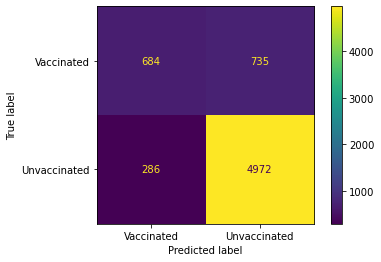

In [94]:
ConfusionMatrixDisplay.from_predictions(y_test, test_pred, display_labels=['Vaccinated', 'Unvaccinated'])

In [95]:
accuracy_score(y_test, test_pred), accuracy_score(y_train, train_pred)

(0.8470870151265538, 0.855716425361957)

In [96]:
precision_score(y_test, test_pred)

0.8712107937620466

In [97]:
recall_score(y_test, test_pred)

0.9456066945606695

In [98]:
roc_auc_score(y_test, test_pred)

0.7138181464346688

In [99]:
balanced_accuracy_score(y_test, test_pred)

0.7138181464346688

### Conclusions

Model|Accuracy|Precision|Recall|AUC|
-----|--------|---------|------|---|
LR feat.engg + SMOTE|0.817|0.899|0.865|0.753|
LR feat as is + SMOTE|0.824|0.901|0.873|0.759|
LR feat as is|0.851|0.876|0.944|0.725|
XGB feat.engg + SMOTE|0.830|0.880|0.910|0.740|
XGB feat as is + SMOTE|0.839|0.886|0.913|0.739|
XGB feat. as is|0.847|0.871|0.945|0.714|